# Álvaro Huertas García

In this notebook we use an approach of feature extraction with TF-IDF adding sentiment information (polarity and subjectivity) and spell-checking with TextBlob. In this notebook the lemmatizer, stop words and the number of vocabulary words selected thanks to the ML_Biomedical notebook. 

This notebook is an attempt to incorporate meta information from documents to improve classification. It is adapted from: https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5

In [0]:
!pip install Unidecode

     |████████████████████████████████| 245kB 3.4MB/s 


In [0]:
import unidecode
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
import sys
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from textblob import TextBlob

import spacy
print('spaCy Version: %s' % (spacy.__version__))
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
spaCy Version: 2.2.4


In [0]:
np.random.seed(1)

In [0]:
COLAB = True

if COLAB:
    import urllib
    # Data
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z",
                              "precision_medicine.zip")
    # Long stop word
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn",
                              "long_stop_words.txt")
    # Clinical stop words
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1M5a92cvQ3L7okuYHBuZh2K1f_MsrupuF",
                              "clinical_stop_words.txt")

In [0]:
f = open("long_stop_words.txt", "+r")
long_stopwords = f.read().split("\n")
len(long_stopwords)

853

In [0]:
f = open("clinical_stop_words.txt", "+r")
clinical_stopwords = f.read().split("\n")
len(clinical_stopwords)

811

In [0]:
!unzip precision_medicine.zip 

Archive:  precision_medicine.zip
   creating: precision_medicine/
  inflating: precision_medicine/Alzheimer_abstracts.tsv  
   creating: __MACOSX/
   creating: __MACOSX/precision_medicine/
  inflating: __MACOSX/precision_medicine/._Alzheimer_abstracts.tsv  
  inflating: precision_medicine/Bladder_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Bladder_Cancer_abstracts.tsv  
  inflating: precision_medicine/Breast_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Breast_Cancer_abstracts.tsv  
  inflating: precision_medicine/Cervical_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Cervical_Cancer_abstracts.tsv  
  inflating: precision_medicine/negative_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._negative_abstracts.tsv  
  inflating: __MACOSX/._precision_medicine  


In [0]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [0]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [0]:
# Variables donde almacenamos cada texto y su etiqueta
narratives = []
labels = []

# Para cada uno de los 5 archivos extraemos sus textos y le asignamos la etiqueta
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

len(narratives), len(labels)

(5000, 5000)

Transform the data into pandas data frame

In [0]:
import pandas as pd
df_biomedic = pd.DataFrame()
df_biomedic["narratives"] = narratives
df_biomedic["labels"] = labels
df_biomedic

,narratives,labels
0,How the cognitive reserve interacts with beta-...,Alzheimer
1,Negative Bias in the Perception and Memory of ...,Alzheimer
2,Anosognosia and Its Relation to Psychiatric Sy...,Alzheimer
3,Family history and APOE4 risk for Alzheimer's ...,Alzheimer
4,Data-driven regions of interest for longitudin...,Alzheimer
...,...,...
4995,Universal Coverage without Universal Access: I...,Negative
4996,Decreased use of glucocorticoids in biological...,Negative
4997,Evaluating the Utility of Single-Locus DNA Bar...,Negative
4998,Convection-driven kinematic dynamos at low Ros...,Negative


In [0]:
print(len(narratives))
dic = {}
unique_labels, counts = np.unique(labels, return_counts=True)
for aa,bb in zip(unique_labels,counts):
    print(aa+':', bb)
    dic[aa] = bb

5000
Alzheimer: 1000
Bladder Cancer: 1000
Breast Cancer: 1000
Cervical Cancer: 1000
Negative: 1000


In [0]:
print(len(df_biomedic['narratives'].iloc[0]))
print(len(narratives[0]))

1842
1842


## Pre-processing



In [0]:
def preprocessor(text, stoptext = "long", lemmatizer = "nltk"):
  sys.stdout.write('.')
  sys.stdout.flush()


  # Text to unicode
  text = unidecode.unidecode(text)

  # Remove introduction words for sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) 

  # Lowercase and remove extra spaces
  text = text.strip().lower()



  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # Substitute p value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant

  # Separate punctation to replace numbers for NUM better
  from string import punctuation
  punctuation_marks = set(punctuation)
  punctuation_marks.update(chr(177))

  for i in punctuation_marks:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)


  # Substitute irrelevant (isolated) numbers by NUM
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  text = re.sub( "\s[0-9]+\s", " num ", text)

  # Tokenize the text
  tokenized_text = nltk.word_tokenize(text)

  

  # Delete Punctuation
  tokenized_text = [i for i in tokenized_text if i not in punctuation_marks]


    # Delete stop words
  if stoptext == "spacy":
    spacy_nlp = spacy.load('en_core_web_sm')
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stop_words = sorted(spacy_stopwords)

  if stoptext == "nltk":
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    stop_words = sorted(nltk_stopwords)

  if stoptext == "clinical":
    stop_words = clinical_stopwords

  if stoptext == "long":
    stop_words = sorted(long_stopwords)

  tokenized_text = [i for i in tokenized_text if i not in stop_words]


  # Lemmanization
  if lemmatizer == "nltk":
    lemmatizer = WordNetLemmatizer().lemmatize
    lemmatized_text = [lemmatizer(word) for word in tokenized_text]

  
  if lemmatizer == "spacy":
    nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(" ".join(tokenized_text))
    lemmatized_text = [token.lemma_ for token in doc]


  # Join all the text  
  full_text = " ".join(lemmatized_text)

  return full_text

You can clean the text individually, but this will be done in the Pipeline

In [0]:
# df_biomedic['clean'] = df_biomedic['narratives'].apply(preprocessor, args = ("nltk", "nltk"))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


Next we are going to create some news variables columns to try to improve the quaity of our classifier, we will create with TextBlob:

   1. Polarity: to check the sentiment of the text
   2. Subjectivity: to check if text is objective or subjective
   



In [0]:
def polarity_txt(text):
  sys.stdout.write('.')
  sys.stdout.flush()
  return TextBlob(text).sentiment[0]



def subj_txt(text):
  sys.stdout.write('.')
  sys.stdout.flush()
  return  TextBlob(text).sentiment[1]


df_biomedic['polarity'] = df_biomedic['narratives'].apply(polarity_txt)
df_biomedic['subjectivity'] = df_biomedic['narratives'].apply(subj_txt)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Check the results

In [0]:
df_biomedic.head(11)

,narratives,labels,polarity,subjectivity
0,How the cognitive reserve interacts with beta-...,Alzheimer,0.076002,0.439965
1,Negative Bias in the Perception and Memory of ...,Alzheimer,0.068687,0.618182
2,Anosognosia and Its Relation to Psychiatric Sy...,Alzheimer,0.113021,0.518750
3,Family history and APOE4 risk for Alzheimer's ...,Alzheimer,0.033088,0.383824
4,Data-driven regions of interest for longitudin...,Alzheimer,0.142308,0.421154
5,"Awareness, apathy, and depression in Alzheimer...",Alzheimer,0.277273,0.470455
6,Dual role of cellular prion protein in normal ...,Alzheimer,0.070455,0.528030
7,Lewy Body Disorders. Dementia syndromes associ...,Alzheimer,0.000000,0.400000
8,Late-Onset Alzheimer Disease. The oldest-old r...,Alzheimer,0.072917,0.549405
9,Early-Onset Alzheimer Disease. Early-onset Alz...,Alzheimer,0.055952,0.438312


Now we define the elements from the Pipeline in charge of combining the metadata information extracted with the feature extraction done with TF-IDF vectorizer. 

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract meta-features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['polarity'], 'sub': row['subjectivity']} for _, row in data.iterrows()]

## Pipeline

In [0]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('clean', Pipeline([
                ('selector', ItemSelector(key='narratives')),
                # We use the paramters selected in the ML-Biomedical notebook
                ('tfidf', TfidfVectorizer( min_df =0, max_df=0.7, max_features=8500, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=preprocessor)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 'subjectivity'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
])

## Split into Train and Test Set

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
X = df_biomedic[['narratives', 'polarity', 'subjectivity']]
y =df_biomedic['labels']
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Original label
codification = [ (encoder.transform(encoder.classes_)[i], encoder.classes_[i])  for i in range(len(encoder.classes_))]
print(codification)


seed = 1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify = y)

# train and test label
train_labels = encoder.classes_[y_train]
test_labels = encoder.classes_[y_test]

[(0, 'Alzheimer'), (1, 'Bladder Cancer'), (2, 'Breast Cancer'), (3, 'Cervical Cancer'), (4, 'Negative')]


In [0]:
pipeline.fit(x_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('clean',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='narratives')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
               

In [0]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [0]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('data_TF_IDF.pkl', 'wb') as f:
    pickle.dump([train_vec, test_vec, y_train, y_test], f)

# For downloading pickle document
from google.colab import files
files.download("data_TF_IDF.pkl")



# Classification algorithms

# Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB


# fit the training dataset on the NB classifier
Naive = naive_bayes.GaussianNB()
Naive.fit(train_vec.todense(), y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(test_vec.todense())

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_test, predictions_NB)*100)
print(metrics.classification_report(y_test, predictions_NB))

Naive Bayes Accuracy Score ->  71.06666666666666
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       300
           1       0.69      0.75      0.72       300
           2       0.67      0.70      0.68       300
           3       0.68      0.66      0.67       300
           4       0.68      0.57      0.62       300

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=True, solver='lbfgs', random_state=0, max_iter=200)

model.fit(train_vec, y_train)


# predict the labels on validation dataset
predictions_LR = model.predict(test_vec)

# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_test, predictions_LR)*100)
print(metrics.classification_report(y_test, predictions_LR))

Logistic Regression Accuracy Score ->  89.06666666666668
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       300
           1       0.91      0.87      0.89       300
           2       0.88      0.88      0.88       300
           3       0.88      0.85      0.87       300
           4       0.82      0.92      0.86       300

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



## L1

In [0]:
param_grid = {'C': np.logspace(-3, 1, 6)} 

gs_Lr = GridSearchCV(LogisticRegression(penalty='l1', max_iter=1000, solver = "liblinear"), cv=5, param_grid=param_grid)
gs_Lr.fit(train_vec, y_train)


# Check the training error to study overfitting
predictions_train = gs_Lr.predict(train_vec)
print("Train Accuracy Score -> ",accuracy_score(y_train, predictions_train)*100)

# predict the labels on validation dataset
predictions_Lr = gs_Lr.predict(test_vec)

# Use accuracy_score function to get the accuracy
print('Best C Parameter: %.2g' % gs_Lr.best_params_['C'])
print("Logistic Regression Lasso L1 Accuracy Score -> ",accuracy_score(y_test, predictions_Lr)*100)
print(metrics.classification_report(y_test, predictions_Lr))

Train Accuracy Score ->  92.2
Best C Parameter: 1.6
Logistic Regression Lasso L1 Accuracy Score ->  92.13333333333334
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       300
           1       0.98      0.92      0.95       300
           2       0.92      0.89      0.91       300
           3       0.93      0.92      0.92       300
           4       0.82      0.94      0.87       300

    accuracy                           0.92      1500
   macro avg       0.93      0.92      0.92      1500
weighted avg       0.93      0.92      0.92      1500



## L2

In [0]:
param_grid = {'C': np.logspace(-3, 1, 6)} 

gs_L2 = GridSearchCV(LogisticRegression(penalty='l2', max_iter=100, n_jobs=-1, solver='saga', multi_class='multinomial'), cv=5, param_grid=param_grid)
gs_L2.fit(train_vec, y_train)

# predict the labels on validation dataset
predictions_L2 = gs_L2.predict(test_vec)

# Use accuracy_score function to get the accuracy
print('Best C Parameter: %.2g' % gs_L2.best_params_['C'])
print("Logistic Regression Ridge L2 Accuracy Score -> ",accuracy_score(y_test, predictions_L2)*100)
print(metrics.classification_report(y_test, predictions_L2))

Best C Parameter: 1.6
Logistic Regression Ridge L2 Accuracy Score ->  89.06666666666668
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       300
           1       0.92      0.87      0.89       300
           2       0.87      0.87      0.87       300
           3       0.88      0.86      0.87       300
           4       0.82      0.92      0.87       300

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



# SVM y SGD

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

In [0]:
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 5
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

[0.88142857 0.87571429 0.88714286 0.88285714 0.90428571]
Mean score: 0.886 (+/-0.010)
[0.87714286 0.86285714 0.88571429 0.89       0.9       ]
Mean score: 0.883 (+/-0.013)
CPU times: user 1.18 s, sys: 3 µs, total: 1.18 s
Wall time: 1.18 s


In [0]:
%%time
from sklearn.metrics import classification_report

# 
clf_sv.fit(train_vec, y_train )
y_pred = clf_sv.predict(test_vec)
print("###### SVC ######")
print("Accuracy:",accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))



clf_sgd.fit(train_vec, y_train )
y_pred = clf_sgd.predict(test_vec)
print("###### SGD ######")
print("Accuracy:",accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

###### SVC ######
Accuracy: 0.8986666666666666
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       300
           1       0.91      0.89      0.90       300
           2       0.87      0.88      0.87       300
           3       0.88      0.85      0.87       300
           4       0.86      0.91      0.89       300

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500

###### SGD ######
Accuracy: 0.8906666666666667
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       300
           1       0.91      0.89      0.90       300
           2       0.86      0.87      0.86       300
           3       0.87      0.86      0.87       300
           4       0.85      0.89      0.87       300

    accuracy                           0.89      1500
   macro avg       0.89      0.89    

## KNN

Primero normalizamos los datos

Segundo aplicamos un GridSearchCV para encontrar el número óptimo de vecinos. 

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.neighbors import KNeighborsClassifier

# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors':[1, 3, 5, 7, 11, 15, 20, 25, 30, 50, 100, 150, 200]}]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
          
    knn = GridSearchCV(
        KNeighborsClassifier(), tuned_parameters, scoring=make_scorer(accuracy_score), cv = 10 
      )
      
    knn.fit(train_vec , y_train)

    print("Best parameters set found on development set:")
    print()
    print(knn.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = knn.cv_results_['mean_test_score']
    stds = knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, knn.predict(test_vec)
    print("Accuracy Score -> ",accuracy_score(y_true, y_pred)*100)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_neighbors': 200}

Grid scores on development set:

0.654 (+/-0.040) for {'n_neighbors': 1}
0.682 (+/-0.054) for {'n_neighbors': 3}
0.717 (+/-0.059) for {'n_neighbors': 5}
0.736 (+/-0.041) for {'n_neighbors': 7}
0.742 (+/-0.045) for {'n_neighbors': 11}
0.751 (+/-0.043) for {'n_neighbors': 15}
0.769 (+/-0.058) for {'n_neighbors': 20}
0.771 (+/-0.046) for {'n_neighbors': 25}
0.779 (+/-0.043) for {'n_neighbors': 30}
0.783 (+/-0.037) for {'n_neighbors': 50}
0.793 (+/-0.035) for {'n_neighbors': 100}
0.793 (+/-0.028) for {'n_neighbors': 150}
0.795 (+/-0.035) for {'n_neighbors': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Accuracy Score ->  79.80000000000001
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       300
           1       0.74      0.87      0.80

## Random Forest

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators':[50, 100, 150, 200, 300, 400, 500, 700],
                     'max_depth': [1, 3, 5, 7]}]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
          
    knn = GridSearchCV(
        RandomForestClassifier( max_depth=3, random_state=0), tuned_parameters, scoring=make_scorer(accuracy_score), cv = 10 
      )
      
    knn.fit(train_vec , y_train)

    print("Best parameters set found on development set:")
    print()
    print(knn.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = knn.cv_results_['mean_test_score']
    stds = knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, knn.predict(test_vec)
    print("Accuracy Score -> ",accuracy_score(y_true, y_pred)*100)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 7, 'n_estimators': 300}

Grid scores on development set:

0.812 (+/-0.029) for {'max_depth': 1, 'n_estimators': 50}
0.878 (+/-0.046) for {'max_depth': 1, 'n_estimators': 100}
0.896 (+/-0.034) for {'max_depth': 1, 'n_estimators': 150}
0.898 (+/-0.020) for {'max_depth': 1, 'n_estimators': 200}
0.894 (+/-0.033) for {'max_depth': 1, 'n_estimators': 300}
0.892 (+/-0.032) for {'max_depth': 1, 'n_estimators': 400}
0.899 (+/-0.029) for {'max_depth': 1, 'n_estimators': 500}
0.897 (+/-0.024) for {'max_depth': 1, 'n_estimators': 700}
0.877 (+/-0.035) for {'max_depth': 3, 'n_estimators': 50}
0.898 (+/-0.028) for {'max_depth': 3, 'n_estimators': 100}
0.901 (+/-0.025) for {'max_depth': 3, 'n_estimators': 150}
0.901 (+/-0.021) for {'max_depth': 3, 'n_estimators': 200}
0.901 (+/-0.026) for {'max_depth': 3, 'n_estimators': 300}
0.903 (+/-0.026) for {'max_depth': 3, 'n_estimators': 400}
0.905 (+/-0.023) 

## Visualization

In [0]:
from google.colab import files
src = list(files.upload().values())[0] # for the heatmap

Saving utils.py to utils.py


In [0]:
open('utils.py','wb').write(src)
import utils

In [0]:
print(codification)

[(0, 'Alzheimer'), (1, 'Bladder Cancer'), (2, 'Breast Cancer'), (3, 'Cervical Cancer'), (4, 'Negative')]


In [0]:
classes = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical Cancer", "Negative"]

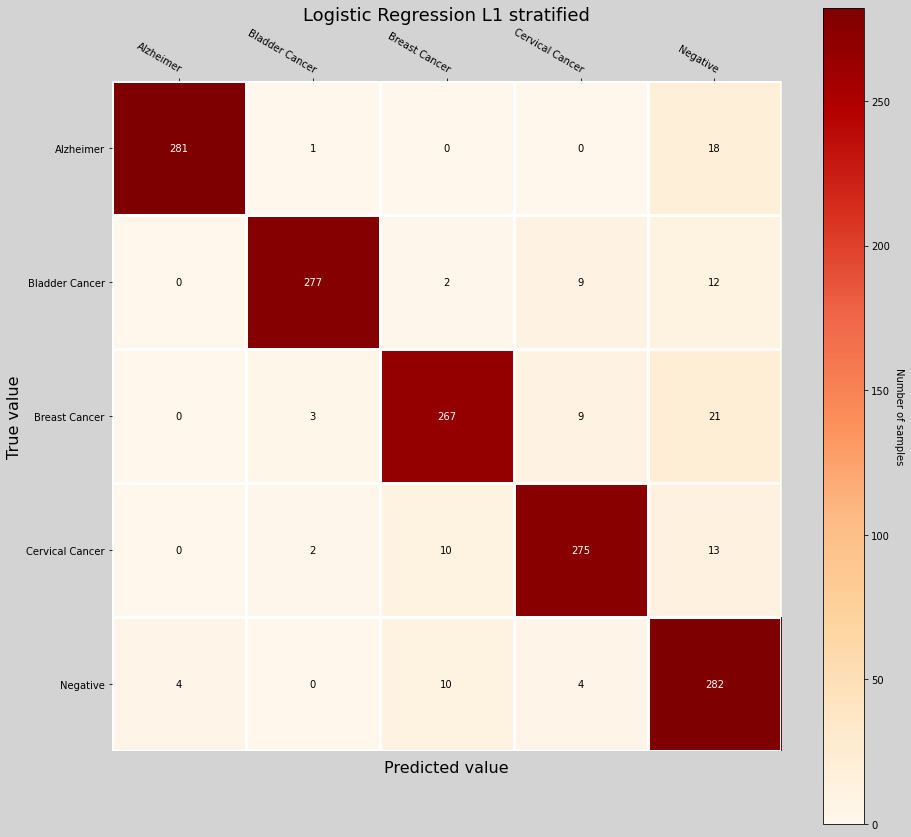

In [0]:
import matplotlib.pyplot as plt
from utils import heatmap, annotate_heatmap
from sklearn.metrics import confusion_matrix
%matplotlib inline

matrix = confusion_matrix(y_test, predictions_Lr)
fig, ax = plt.subplots(figsize=(15,15))
im, cbar = heatmap(matrix, classes, classes, ax=ax,
                   cmap="OrRd", cbarlabel="Number of samples")
ax.set_ylabel('True value', fontsize = 16)
ax.set_xlabel('Predicted value', fontsize = 16)
ax.set_title("Logistic Regression L1 stratified", fontsize = 18)
fig.patch.set_facecolor('lightgrey')
texts = annotate_heatmap(im, valfmt="{x:.0f}")

In [0]:
d = dict(zip(set(train_labels), ["blue", "yellow", "green", "red", "orange"]))
colors = [ d[train_labels[i]]   for i in range(len(train_labels))]

## T-SNE 2D

In [0]:
# importing bokeh library for interactive data visualization
from bokeh.palettes import Category10_5
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

# defining the chart
output_notebook()
fig = bp.figure(plot_width=800, plot_height=700, title="A map of train text (interactive legend)",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(train_vec)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df["label"] = train_labels

# Select differnt text class
alzhemier = tsne_df[tsne_df["label"] == "Alzheimer"][["x", "y", "label"]]
bladder = tsne_df[tsne_df["label"] == "Bladder Cancer"][["x", "y", "label"]]
breast = tsne_df[tsne_df["label"] == "Breast Cancer"][["x", "y", "label"]]
cervical = tsne_df[tsne_df["label"] == "Cervical Cancer"][["x", "y", "label"]]
negative = tsne_df[tsne_df["label"] == "Negative"][["x", "y", "label"]]

# Data list
data_list = [alzhemier, bladder, breast, cervical, negative]

# Labels for the plot
name_list = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical", "Negative"]

# plotting. the corresponding word appears when you hover on the data point.
for data, name, color in zip(data_list, name_list, Category10_5):
    fig.scatter(x='x', y='y', source=data, color = color, legend_label = name, 
                size = 5)


fig.legend.location = "top_left"
fig.legend.click_policy="hide"
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"Category": "@label", "First tokens": "@tokens"}


show(fig)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3500 samples in 0.002s...
[t-SNE] Computed neighbors for 3500 samples in 0.977s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3500
[t-SNE] Computed conditional probabilities for sample 2000 / 3500
[t-SNE] Computed conditional probabilities for sample 3000 / 3500
[t-SNE] Computed conditional probabilities for sample 3500 / 3500
[t-SNE] Mean sigma: 0.260926
[t-SNE] KL divergence after 100 iterations with early exaggeration: 84.693771
[t-SNE] KL divergence after 1000 iterations: 2.155558


In [0]:
import plotly.express as px

# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components=3, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(train_vec)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v , columns=['x', 'y', "z"])
tsne_df["label"] = train_labels
tsne_df["color"] = colors


fig = px.scatter_3d(tsne_df, x="x", y='y', z='z',
              color="label")




fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="T-SNE Text",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title")


fig.update_layout(legend= {'itemsizing': 'constant'})

for trace in fig.data:
    trace.name = trace.name.split('=')[1]
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3500 samples in 0.002s...
[t-SNE] Computed neighbors for 3500 samples in 0.886s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3500
[t-SNE] Computed conditional probabilities for sample 2000 / 3500
[t-SNE] Computed conditional probabilities for sample 3000 / 3500
[t-SNE] Computed conditional probabilities for sample 3500 / 3500
[t-SNE] Mean sigma: 0.260926
[t-SNE] KL divergence after 50 iterations with early exaggeration: 84.693771
[t-SNE] KL divergence after 1000 iterations: 2.001717


## PCA 2D

In [0]:
# importing bokeh library for interactive data visualization
from bokeh.palettes import Category10_5
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

from sklearn.decomposition import PCA

# defining the chart
output_notebook()
fig = bp.figure(plot_width=700, plot_height=600, title="A map of documents (PCA)",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)



# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components=2)
wv_pca = pca.fit_transform(train_vec.todense())
print("Explained variance", pca.explained_variance_ratio_)

# putting everything in a dataframe
tsne_df = pd.DataFrame(wv_pca, columns=['x', 'y'])
tsne_df["label"] = train_labels
tsne_df["color"] = colors
# tsne_df["tokens"] = [lines[:200] for lines in non_vector_train]

# Select differnt text class
alzhemier = tsne_df[tsne_df["label"] == "Alzheimer"][["x", "y", "label"]]
bladder = tsne_df[tsne_df["label"] == "Bladder Cancer"][["x", "y", "label"]]
breast = tsne_df[tsne_df["label"] == "Breast Cancer"][["x", "y", "label"]]
cervical = tsne_df[tsne_df["label"] == "Cervical Cancer"][["x", "y", "label"]]
negative = tsne_df[tsne_df["label"] == "Negative"][["x", "y", "label"]]

# Data list
data_list = [alzhemier, bladder, breast, cervical, negative]

# Labels for the plot
name_list = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical", "Negative"]

# plotting. the corresponding word appears when you hover on the data point.
for data, name, color in zip(data_list, name_list, Category10_5):
    fig.scatter(x='x', y='y', source=data, color = color, legend_label = name, 
                size = 5)

fig.yaxis.axis_label = "Pressure"

fig.legend.label_text_font_size = "24px"
fig.legend.location = "top_left"
fig.legend.click_policy="hide"
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"Category": "@label"}


show(fig)

Explained variance [0.02805265 0.01470668]


In [0]:
import plotly.express as px

# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components=3)
wv_pca = pca.fit_transform(train_vec.todense())

# putting everything in a dataframe
tsne_df = pd.DataFrame(wv_pca , columns=['x', 'y', "z"])
tsne_df["label"] = train_labels


fig = px.scatter_3d(tsne_df, x="x", y='y', z='z',
              color="label")




fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="PCA Text",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title")


fig.update_layout(legend= {'itemsizing': 'constant'})

for trace in fig.data:
    trace.name = trace.name.split('=')[1]
fig.show()